#**Setup & Imports**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

# --- Configuration ---
SNP_MATRIX_FILE = "/content/drive/MyDrive/AMR/Giessen_dataset/cip_ctx_ctz_gen_multi_data.csv"
PHENOTYPES_FILE = "/content/drive/MyDrive/AMR/Giessen_dataset/cip_ctx_ctz_gen_pheno.csv"
TARGET_ANTIBIOTIC = "CIP"

# Model Hyperparameters for 1D CNN
VOCAB_SIZE = 5      # N:0, A:1, G:2, C:3, T:4
EMBEDDING_DIM = 64  # Dimension for the embedding layer (can be tuned)
MAX_SEQ_LEN = None  # Will be determined from data
DROPOUT_RATE = 0.45  # Regularization for Dense layers
CONV_DROPOUT_RATE = 0.15 # Regularization for Conv layers

# Training Hyperparameters
EPOCHS = 120 # Can be tuned
BATCH_SIZE = 32 # Can be tuned
LEARNING_RATE = 1e-3 # Can be tuned
VALIDATION_SPLIT = 0.15
TEST_SPLIT = 0.15

# Set seed for reproducibility (Can be shuffled)
tf.random.set_seed(42)
np.random.seed(42)

# Check for GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Using GPU: {gpus[0].name}")
    except RuntimeError as e:
        print(e)
else:
    print("Using CPU")


Using GPU: /physical_device:GPU:0


# **Initial Preprocessing**

In [3]:
print("\n--- Loading and Preprocessing Data for 1D CNN ---")
try:
    snp_df_raw = pd.read_csv(SNP_MATRIX_FILE)
    pheno_df = pd.read_csv(PHENOTYPES_FILE)
except FileNotFoundError:
    print(f"ERROR: Ensure '{SNP_MATRIX_FILE}' and '{PHENOTYPES_FILE}' are in the same directory.")
    exit()

print(f"Raw SNP matrix shape: {snp_df_raw.shape}")
print(f"Phenotypes shape: {pheno_df.shape}")

# Set 'prename' as index for easy merging
snp_df = snp_df_raw.set_index('prename')
pheno_df = pheno_df.set_index('prename')

# Merge SNP data with phenotype data
merged_df = snp_df.join(pheno_df[TARGET_ANTIBIOTIC], how='inner')
print(f"Merged data shape: {merged_df.shape}")

# Handle potential NaN values
merged_df = merged_df.dropna(subset=[TARGET_ANTIBIOTIC])
# Fill NaNs in SNP features with 0 (assuming this corresponds to 'N' or unknown)
merged_df = merged_df.fillna(0)
print(f"Shape after dropping NaNs in target and filling NaNs in features: {merged_df.shape}")

# Separate features (SNPs) and labels
labels = merged_df[TARGET_ANTIBIOTIC].values.astype(np.int32)
features_df = merged_df.drop(columns=[TARGET_ANTIBIOTIC])

# Store original SNP position names (column headers) for potential interpretation later [Couldn't implement for CNNs yet]
snp_position_names = features_df.columns.tolist()

# --- Integer Encoding (Data is already in this format 0-4) ---
# Just ensuring data is integer type for the embedding layer
X_integer_encoded = features_df.values.astype(np.int32)

MAX_SEQ_LEN = X_integer_encoded.shape[1] # This is the number of SNP positions
print(f"Sequence length (number of SNPs): {MAX_SEQ_LEN}")
print(f"Labels shape: {labels.shape}")
print(f"Class distribution: Resistant (1): {np.sum(labels == 1)}, Susceptible (0): {np.sum(labels == 0)}")
if np.any(X_integer_encoded >= VOCAB_SIZE) or np.any(X_integer_encoded < 0):
    print("WARNING: SNP values out of expected range [0, VOCAB_SIZE-1]. Check encoding.")


--- Loading and Preprocessing Data for 1D CNN ---
Raw SNP matrix shape: (809, 60937)
Phenotypes shape: (809, 5)
Merged data shape: (809, 60937)
Shape after dropping NaNs in target and filling NaNs in features: (809, 60937)
Sequence length (number of SNPs): 60936
Labels shape: (809,)
Class distribution: Resistant (1): 366, Susceptible (0): 443


# **Data Splitting**

In [4]:
print("\n--- Splitting Data ---")

# Spliting data into training + validation and a final test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_integer_encoded, labels, # Use integer encoded features
    test_size=TEST_SPLIT,
    random_state=42,
    stratify=labels
)

# Then, splitting training + validation into training and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=VALIDATION_SPLIT / (1 - TEST_SPLIT), # Correct calculation for the remaining data
    random_state=42,
    stratify=y_train_val
)

print(f"Training samples: {X_train.shape[0]}, Sequence Length: {X_train.shape[1]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")


--- Splitting Data ---
Training samples: 565, Sequence Length: 60936
Validation samples: 122
Test samples: 122


# **1D CNN Model Definition**

In [5]:
print("\n--- Defining the 1D CNN Model (Extended to 6 Convolutional Blocks) ---")

def build_cnn1d_model_extended(maxlen, vocab_size, embed_dim, num_classes_binary, conv_dropout_rate, dense_dropout_rate):
    inputs = keras.Input(shape=(maxlen,), name="snp_input_sequence")

    # Embedding layer
    x = layers.Embedding(input_dim=vocab_size,
                         output_dim=embed_dim,
                         input_length=maxlen,
                         name="embedding_layer")(inputs)
    # x = layers.SpatialDropout1D(0.15)(x) # Optional: Dropout after embedding, slightly increased (I don't recommend it!)

    # Convolutional blocks - Doubled
    # Block 1
    x = layers.Conv1D(filters=128, kernel_size=7, padding="same",
                      kernel_regularizer=regularizers.l2(0.001), name="conv1d_1")(x)
    x = layers.BatchNormalization(name="batchnorm_1")(x)
    x = layers.Activation("relu", name="relu_1")(x)
    x = layers.MaxPooling1D(pool_size=2, name="maxpool_1")(x) # Adjusted pool_size slightly
    # x = layers.Dropout(conv_dropout_rate, name="conv_dropout_1")(x)    ## Worked well after commenting out this layer

    # Block 2
    x = layers.Conv1D(filters=128, kernel_size=7, padding="same", # Repeating similar block
                      kernel_regularizer=regularizers.l2(0.001), name="conv1d_2")(x)
    x = layers.BatchNormalization(name="batchnorm_2")(x)
    x = layers.Activation("relu", name="relu_2")(x)
    x = layers.MaxPooling1D(pool_size=2, name="maxpool_2")(x) # Adjusted pool_size
    # x = layers.Dropout(conv_dropout_rate, name="conv_dropout_2")(x)    ## Worked well after commenting out this layer

    # Block 3
    x = layers.Conv1D(filters=64, kernel_size=5, padding="same",
                      kernel_regularizer=regularizers.l2(0.001), name="conv1d_3")(x)
    x = layers.BatchNormalization(name="batchnorm_3")(x)
    x = layers.Activation("relu", name="relu_3")(x)
    x = layers.MaxPooling1D(pool_size=2, name="maxpool_3")(x) # Adjusted pool_size
    # x = layers.Dropout(conv_dropout_rate, name="conv_dropout_3")(x)    ## Worked well after commenting out this layer

    # Block 4
    x = layers.Conv1D(filters=64, kernel_size=5, padding="same", # Repeating similar block
                      kernel_regularizer=regularizers.l2(0.001), name="conv1d_4")(x)
    x = layers.BatchNormalization(name="batchnorm_4")(x)
    x = layers.Activation("relu", name="relu_4")(x)
    x = layers.MaxPooling1D(pool_size=2, name="maxpool_4")(x) # Adjusted pool_size
    # x = layers.Dropout(conv_dropout_rate, name="conv_dropout_4")(x)    ## Worked well after commenting out this layer

    # Block 5
    x = layers.Conv1D(filters=32, kernel_size=3, padding="same",
                      kernel_regularizer=regularizers.l2(0.001), name="conv1d_5")(x)
    x = layers.BatchNormalization(name="batchnorm_5")(x)
    x = layers.Activation("relu", name="relu_5")(x)
    # No MaxPooling after the last few conv blocks sometimes helps retain info before GlobalPooling
    x = layers.Dropout(conv_dropout_rate, name="conv_dropout_5")(x)


    # Block 6
    x = layers.Conv1D(filters=32, kernel_size=3, padding="same",
                      kernel_regularizer=regularizers.l2(0.001), name="conv1d_6")(x)
    x = layers.BatchNormalization(name="batchnorm_6")(x)
    x = layers.Activation("relu", name="relu_6")(x)
    # No MaxPooling here either
    x = layers.Dropout(conv_dropout_rate, name="conv_dropout_6")(x)


    # Flatten or Pool for Dense layers
    x = layers.GlobalMaxPooling1D(name="global_max_pooling")(x)         ## GlobalMaxPooling worked better than flattening and GlobalAvgPooling
    # x = layers.GlobalAveragePooling1D(name="global_avg_pooling")(x)
    # x = layers.Flatten()(x) # Alternative

    # Dense classification head (kept the same as your request)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001), name="dense_1")(x)
    x = layers.Dropout(dense_dropout_rate, name="dense_dropout_1")(x)
    # x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), name="dense_2")(x)        ## Worked well after removing this dense layer
    # x = layers.Dropout(dense_dropout_rate, name="dense_dropout_2")(x)     ## Worked well after commenting out this layer

    outputs = layers.Dense(num_classes_binary, activation='sigmoid', name="output_layer")(x)

    model = keras.Model(inputs, outputs, name="Extended_CNN1D_AMR_Model") # Added a model name
    return model

# MAX_SEQ_LEN, VOCAB_SIZE, EMBEDDING_DIM, CONV_DROPOUT_RATE, DROPOUT_RATE are defined in Cell 1
cnn_model = build_cnn1d_model_extended(MAX_SEQ_LEN, VOCAB_SIZE, EMBEDDING_DIM, 1, CONV_DROPOUT_RATE, DROPOUT_RATE)

cnn_model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=LEARNING_RATE), # Or Adam
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc'), keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')]
)

cnn_model.summary()


--- Defining the 1D CNN Model (Extended to 6 Convolutional Blocks) ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "Extended_CNN1D_AMR_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ snp_input_sequence (InputLayer) │ (None, 60936)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Embedding)     │ (None, 60936, 64)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 60936, 128)     │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 60936, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_1 (Activation)             │ (None, 60936, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling1D)        │ (None, 30468, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 30468, 128)     │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 30468, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_2 (Activation)             │ (None, 30468, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling1D)        │ (None, 15234, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 15234, 64)      │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 15234, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_3 (Activation)             │ (None, 15234, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_3 (MaxPooling1D)        │ (None, 7617, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 7617, 64)       │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 7617, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_4 (Activation)             │ (None, 7617, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_4 (MaxPooling1D)        │ (None, 3808, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 3808, 32)       │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_5                     │ (None, 3808, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_5 (Activation)             │ (None, 3808, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dropout_5 (Dropout)        │ (None, 3808, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 249,601 (975.00 KB)

 Trainable params: 248,705 (971.50 KB)

 Non-trainable params: 896 (3.50 KB)

# **Model Training**


--- Starting 1D CNN Model Training ---
Class weights for CNN: {0: np.float64(0.9130925507900677), 1: np.float64(1.105191256830601)}
Epoch 1/120
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 970ms/step - accuracy: 0.5616 - auc: 0.5930 - loss: 1.3995 - precision: 0.5075 - recall: 0.5125 - val_accuracy: 0.4508 - val_auc: 0.5000 - val_loss: 1.1857 - val_precision: 0.4508 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/120
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.6822 - auc: 0.7600 - loss: 1.1360 - precision: 0.6236 - recall: 0.7175 - val_accuracy: 0.4508 - val_auc: 0.5810 - val_loss: 1.1882 - val_precision: 0.4508 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/120
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.7137 - auc: 0.7882 - loss: 1.0735 - precision: 0.6616 - recall: 0.7378 - val_accuracy: 0.4508 - val_auc: 0.5123 - val_loss: 1.1880 - val_precision: 0.4508 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/120
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.7

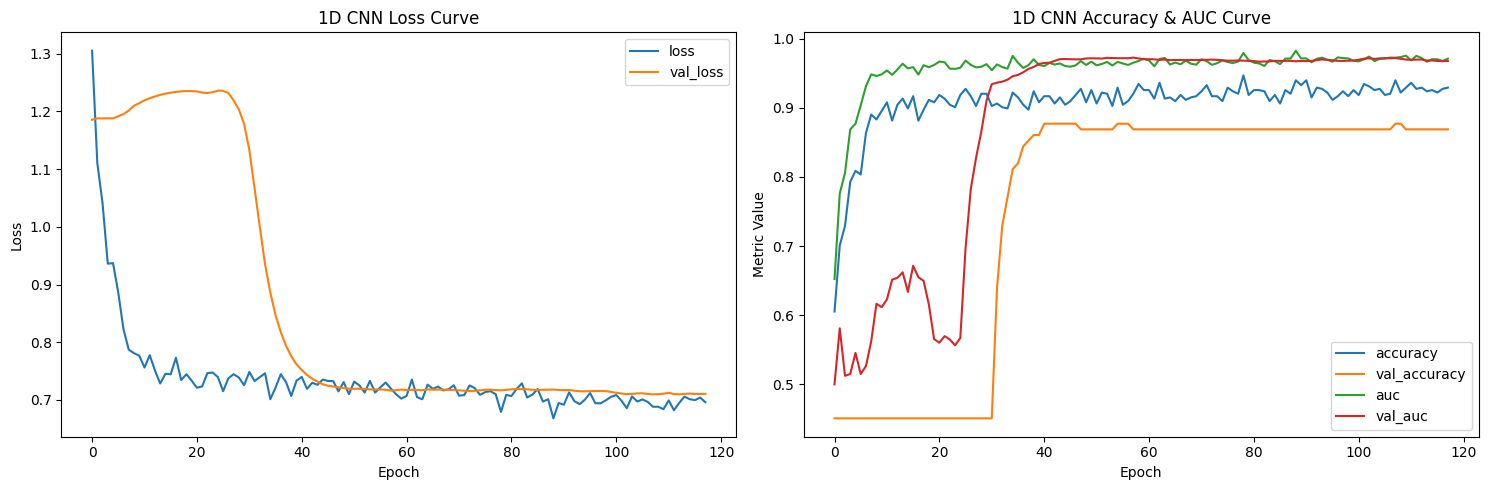

In [6]:
print("\n--- Starting 1D CNN Model Training ---")

# Calculate class weights for imbalanced dataset
neg_total, pos_total = np.bincount(labels) # Use original full 'labels' array
total_samples = neg_total + pos_total
weight_for_0_cnn = (1 / neg_total) * (total_samples / 2.0) if neg_total > 0 else 0
weight_for_1_cnn = (1 / pos_total) * (total_samples / 2.0) if pos_total > 0 else 0
class_weight_cnn = {0: weight_for_0_cnn, 1: weight_for_1_cnn}

print(f"Class weights for CNN: {class_weight_cnn}")

callbacks_list_cnn = [
    keras.callbacks.ModelCheckpoint(
        filepath="best_cnn1d_model.keras",
        save_best_only=True,
        monitor="val_auc", # Monitoring validation AUC for best model
        mode="max"
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_auc",
        patience=60,         # Stop if val_auc doesn't improve for 60 epochs (a bit too much but it works!)
        mode="max",
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=4,
        min_lr=5e-6        # Can be tuned
    )
]

history_cnn = cnn_model.fit(
    X_train, y_train, # X_train should be integer encoded
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val), # X_val should be integer encoded
    callbacks=callbacks_list_cnn,
    class_weight=class_weight_cnn
)

print("--- 1D CNN Training Finished ---")

# Plot training history
history_df_cnn = pd.DataFrame(history_cnn.history)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
history_df_cnn[['loss', 'val_loss']].plot(ax=axes[0])
axes[0].set_title('1D CNN Loss Curve')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
history_df_cnn[['accuracy', 'val_accuracy', 'auc', 'val_auc']].plot(ax=axes[1])
axes[1].set_title('1D CNN Accuracy & AUC Curve')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Metric Value')
plt.tight_layout()
plt.show()

# **Model Evaluation**


--- Evaluating 1D CNN Model on Test Set ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 286ms/step - accuracy: 0.9223 - auc: 0.9798 - loss: 0.6774 - precision: 0.9013 - recall: 0.9174

1D CNN Test Loss: 0.7073
1D CNN Test Accuracy: 0.9098
1D CNN Test AUC: 0.9676
1D CNN Test Precision: 0.9074
1D CNN Test Recall: 0.8909

1D CNN Classification Report:
                 precision    recall  f1-score   support

Susceptible (0)       0.91      0.93      0.92        67
  Resistant (1)       0.91      0.89      0.90        55

       accuracy                           0.91       122
      macro avg       0.91      0.91      0.91       122
   weighted avg       0.91      0.91      0.91       122


1D CNN Confusion Matrix:
[[62  5]
 [ 6 49]]


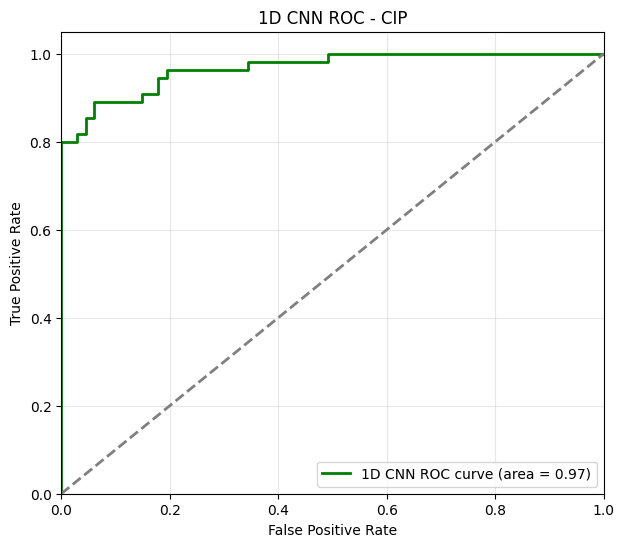

In [7]:
print("\n--- Evaluating 1D CNN Model on Test Set ---")

# Load the best CNN model
best_cnn_model = keras.models.load_model("best_cnn1d_model.keras")

test_loss_cnn, test_acc_cnn, test_auc_cnn, test_precision_cnn, test_recall_cnn = best_cnn_model.evaluate(
    X_test, y_test, verbose=1 # X_test should be integer encoded
)

print(f"\n1D CNN Test Loss: {test_loss_cnn:.4f}")
print(f"1D CNN Test Accuracy: {test_acc_cnn:.4f}")
print(f"1D CNN Test AUC: {test_auc_cnn:.4f}")
print(f"1D CNN Test Precision: {test_precision_cnn:.4f}")
print(f"1D CNN Test Recall: {test_recall_cnn:.4f}")

y_pred_probs_cnn = best_cnn_model.predict(X_test, verbose=0).ravel()
y_pred_classes_cnn = (y_pred_probs_cnn > 0.5).astype(int)

print("\n1D CNN Classification Report:")
print(classification_report(y_test, y_pred_classes_cnn, target_names=["Susceptible (0)", "Resistant (1)"]))

print("\n1D CNN Confusion Matrix:")
cm_cnn = confusion_matrix(y_test, y_pred_classes_cnn)
print(cm_cnn)

# Plot ROC Curve for CNN
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_pred_probs_cnn)
plt.figure(figsize=(7, 6))
plt.plot(fpr_cnn, tpr_cnn, color='green', lw=2, label=f'1D CNN ROC curve (area = {test_auc_cnn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'1D CNN ROC - {TARGET_ANTIBIOTIC}')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# **Interpretation?**